#Tech-Challenge

##Problema de Negócio

O objetivo é identificar quais são os melhores indicadores para prever os custos médicos individuais cobrados pelo seguro de saúde.

##Base de Dados

Este conjunto de dados consiste nas seguintes características: idade, sexo, IMC, fumante, região e custo médico.

##Desafio

Você é um profissional encarregado de desenvolver um modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde.

#Aplicação do Modelo de Regressão Multipla

###Importação dos dados
Aqui os dados que serão usados como base do problema são importados.

In [83]:
# ! pip install pandas

import pandas as pd
# Carregamento dos dados
dados = pd.read_csv("custos_medicos.csv.csv")
dados.head(290)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
285,46,male,26.620,1,no,southeast,7742.10980
286,46,female,48.070,2,no,northeast,9432.92530
287,63,female,26.220,0,no,northwest,14256.19280
288,59,female,36.765,1,yes,northeast,47896.79135


###Exploração da base de dados
Nesse bloco, iremos explorar a base de dados e suas características.

In [84]:
dados.shape

(1338, 7)

In [85]:
# set(dados.charges)

**Interferência sobre a base de dados:**

Variável Target: No nosso case a target é a coluna charges.

**Analisando os dados**

In [86]:
# Estatísticas descritivas
dados.describe()
# visulizacao dos int,float

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [87]:
# Análise descritiva
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Analisando as váriavies númericas:

In [88]:
# ! pip install seaborn
import seaborn as sb

Analisando as variáveis numéricas:

Vamos analisar e compreender a distribuição dos dados para cada métrica de pontuação de seguro de saude. Será que temos outliers na base?

<Axes: xlabel='age'>

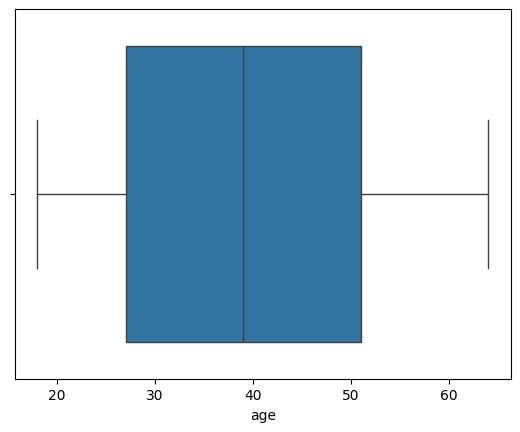

In [89]:
sb.boxplot(x=dados["age"])

In [90]:
print(dados['age'].min())
print(dados['age'].max())

18
64


<Axes: xlabel='age', ylabel='Count'>

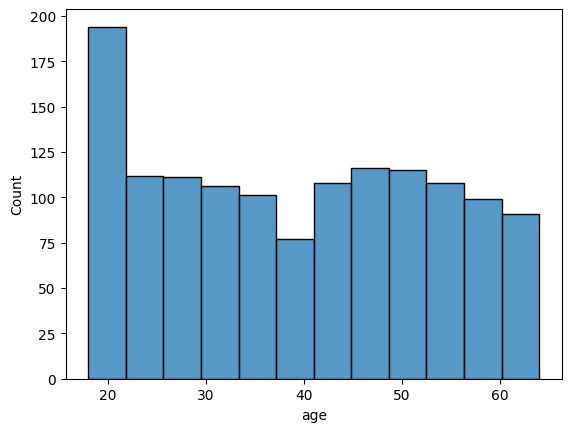

In [91]:
sb.histplot(data=dados, x="age")

<Axes: xlabel='bmi', ylabel='Count'>

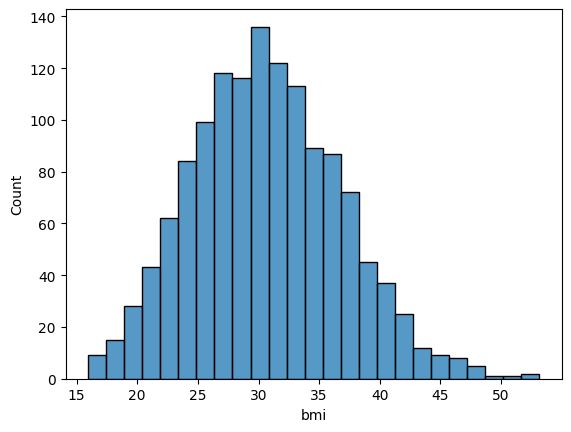

In [92]:
sb.histplot(data=dados, x="bmi")

<Axes: xlabel='bmi'>

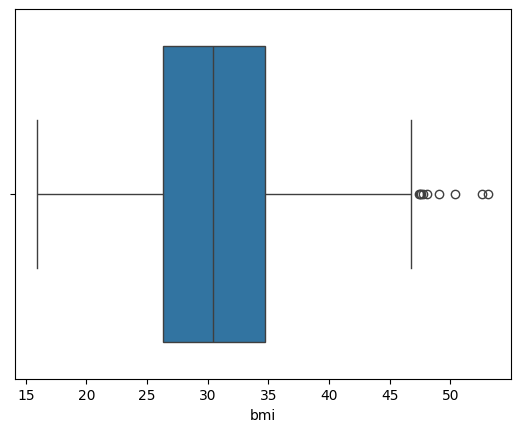

In [93]:
sb.boxplot(x=dados["bmi"])

<Axes: xlabel='smoker'>

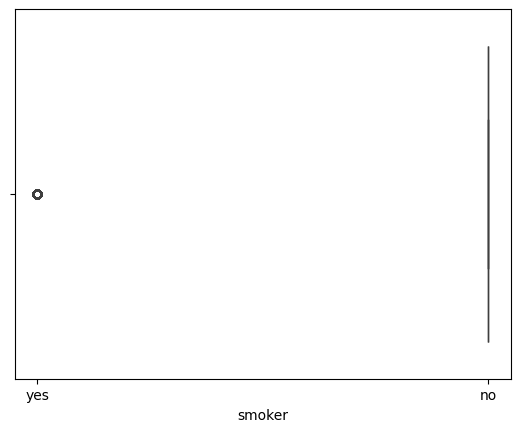

In [94]:
sb.boxplot(x=dados["smoker"])

<Axes: xlabel='smoker', ylabel='Count'>

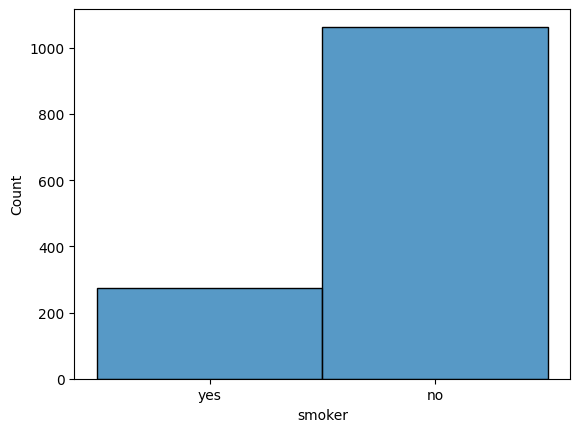

In [95]:
sb.histplot(data=dados, x="smoker")

<Axes: xlabel='charges'>

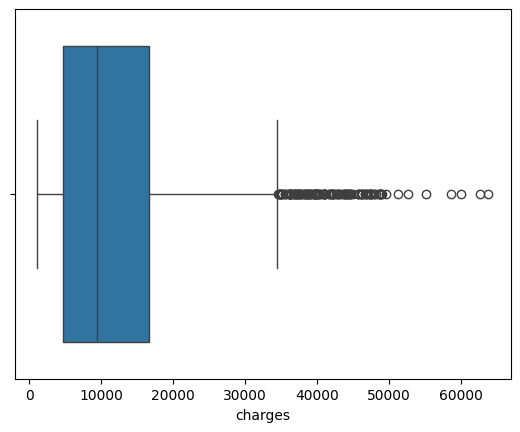

In [96]:
sb.boxplot(x=dados["charges"])

<Axes: xlabel='charges', ylabel='Count'>

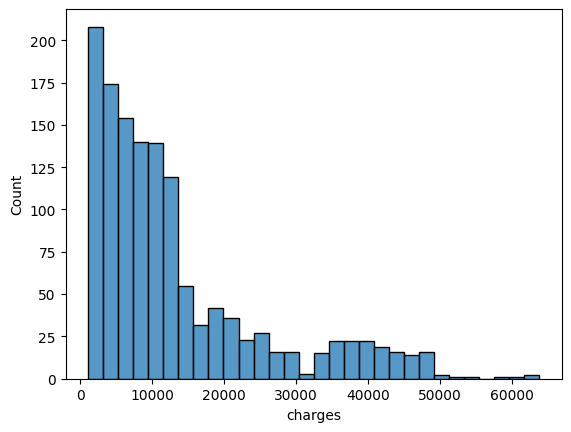

In [97]:
sb.histplot(data=dados, x="charges")

###Analise de correlação

1. Aplicar o Label Encoder para converter todos os atributos não-numerico para o numerico

In [98]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

dados['sex'] = label_encoder.fit_transform(dados['sex'])
dados['smoker'] = label_encoder.fit_transform(dados['smoker'])
dados['region'] = label_encoder.fit_transform(dados['region'])

2. Fazer a analise de correlação entre os campos usando a matriz de correlação

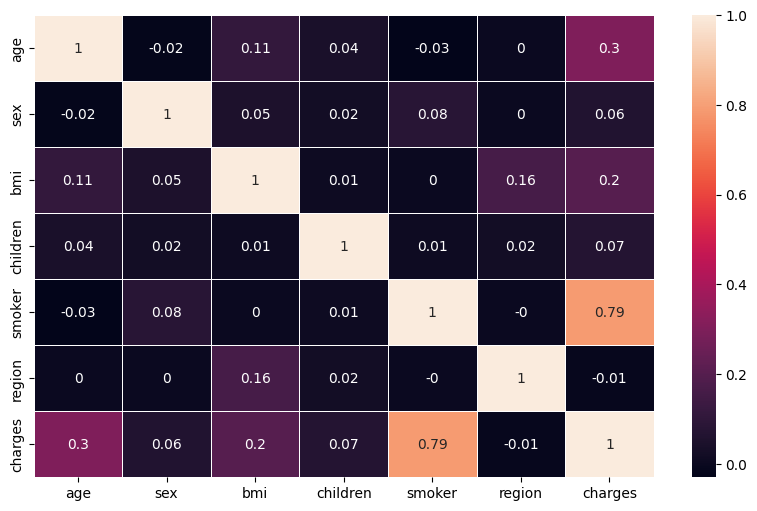

In [99]:
# A correlacao esta inconsistente
# # ! pip install matplotlib

import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# Supondo que 'dados' seja seu DataFrame
# Filtrar colunas numéricas

numeric_dados = dados.select_dtypes('number')
# Calcular a matriz de correlação
correlation_matrix = numeric_dados.corr().round(2)
# arrendondo os valores das correlacoes
fig, ax = plt.subplots(figsize=(10, 6))
sb.heatmap(data= correlation_matrix, annot=True, linewidths=.5, ax=ax)
plt.show()



### Normalização dos dados

Função para aplicar o **MinMaxScaler**, em que todos os valores dos dados serão transformados para o intervalo entre **0 e 1**. A classe será chamada no pipeline de tratamento dos dados.

In [100]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

class CustomMinMaxScaler(BaseEstimator, TransformerMixin):
    """
    Classe personalizada para normalizar dados de treino e teste separadamente.

    Atributos:
        scaler_treino: Objeto MinMaxScaler ajustado aos dados de treino.
        scaler_teste: Objeto MinMaxScaler ajustado aos dados de teste.

    Métodos:
        fit(X_treino): Ajusta o scaler de treino.
        transform(X): Aplica o scaling aos dados de treino ou teste.
        inverse_transform(X): Aplica o inverse scaling aos dados escalados.
    """

    def __init__(self, columns):
        """
        Inicializa a instância da classe.

        Parâmetros:
            columns: Lista de nomes de colunas a serem escalonadas.
        """
        self.columns = columns
        self.scaler_treino = MinMaxScaler()
        self.scaler_teste = MinMaxScaler()

    def fit(self, X_treino):
        """
        Ajusta o scaler de treino aos dados de treino.

        Parâmetros:
            X_treino: Matriz NumPy contendo os dados de treino.

        Retorno:
            Objeto CustomMinMaxScaler.
        """
        self.scaler_treino.fit(X_treino[self.columns])
        return self

    def transform(self, X):
        """
        Aplica o scaling aos dados de treino ou teste.

        Parâmetros:
            X: Matriz NumPy contendo os dados a serem escalados.

        Retorno:
            Matriz NumPy contendo os dados escalados.
        """
        if X.shape[1] == len(self.columns):
            # Dados de treino
            return self.scaler_treino.transform(X[self.columns])
        else:
            # Dados de teste
            return self.scaler_teste.transform(X[self.columns])

    def inverse_transform(self, X):
        """
        Aplica o inverse scaling aos dados escalados.

        Parâmetros:
            X: Matriz NumPy contendo os dados escalados.

        Retorno:
            Matriz NumPy contendo os dados originais.
        """
        if X.shape[1] == len(self.columns):
            # Dados de treino
            return self.scaler_treino.inverse_transform(X[self.columns])
        else:
            # Dados de teste
            return self.scaler_teste.transform(X[self.columns])


###Separação da base em treino e teste

Aqui as bases de treino e teste são separadas antes da normalização ser realizada, de forma que os dados de treino não influenciem os dados de teste, o que pode deixar os resultados do modelo enviesado.

In [101]:
from sklearn.model_selection import train_test_split

In [102]:
X = dados[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
y = dados['charges']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

In [104]:
print(X_train.shape, X_test.shape)

(896, 6) (442, 6)


### Pipeline de tratamento de dados

Agora vamos colocar na pipeline todo os tratamentos dos dados necessários nas bases de treino e teste.

In [105]:
from sklearn.pipeline import Pipeline

# Crie uma única instância do scaler
scaler = CustomMinMaxScaler(columns=['age', 'sex', 'bmi', 'children', 'smoker', 'region'])

def pipeline_treino(df):
  pipeline = Pipeline([('min_max', scaler)])
  df_pipeline = pipeline.fit_transform(df)

  # Converta o resultado para DataFrame
  df_pipeline_train = pd.DataFrame(df_pipeline, columns=df.columns)
  return df_pipeline_train


def pipeline_teste(df):
  pipeline = Pipeline([('min_max', scaler)])
  df_pipeline = pipeline.transform(df)

  # Converta o resultado para DataFrame
  df_pipeline_test = pd.DataFrame(df_pipeline, columns=df.columns)
  return df_pipeline_test


In [106]:
# Utilize as pipelines para normalizar os dados de treino e teste
train = pipeline_treino(X_train)
test =  pipeline_teste(X_test)

In [107]:
X_train

,age,sex,bmi,children,smoker,region
1046,43,0,25.080,0,0,0
682,39,1,35.300,2,1,3
1037,45,0,30.495,1,1,1
490,19,0,32.900,0,0,3
39,60,1,39.900,0,1,3
...,...,...,...,...,...,...
1095,18,0,31.350,4,0,0
1130,39,0,23.870,5,0,2
1294,58,1,25.175,0,0,0
860,37,0,47.600,2,1,3


In [108]:
train

,age,sex,bmi,children,smoker,region
0,0.543478,0.0,0.245359,0.0,0.0,0.000000
1,0.456522,1.0,0.520312,0.4,1.0,1.000000
2,0.586957,0.0,0.391041,0.2,1.0,0.333333
3,0.021739,0.0,0.455744,0.0,0.0,1.000000
4,0.913043,1.0,0.644068,0.0,1.0,1.000000
...,...,...,...,...,...,...
891,0.000000,0.0,0.414044,0.8,0.0,0.000000
892,0.456522,0.0,0.212806,1.0,0.0,0.666667
893,0.869565,1.0,0.247915,0.0,0.0,0.000000
894,0.413043,0.0,0.851224,0.4,1.0,1.000000


### Modelo

Aqui o modelo de regressão multipla será aplicado.